In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from collections import Counter

CAT_1 = {'No_Access':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
CAT_2 = {'No_Access':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}

class Ordinal_Map(BaseEstimator, TransformerMixin):
    def __init__(self,fill_dict): # no *args or **kargs
        self.fill_dict = fill_dict
    def fit(self, X, y=None):
         return self                                 
    def transform(self, X, y=None):
        return X.apply(lambda x: x.map(self.fill_dict),axis=1)

def ret_value(X):
    num_columns = X.shape[1]
    arr_common = []
    x = pd.Series([])
    for col_num in range(num_columns):
        arr_common.append(X.iloc[:,col_num].value_counts().index[0])
        to_concat = X.iloc[:,col_num].fillna(arr_common[col_num])
        x = to_concat if len(x) == 0 else pd.concat([x, to_concat],axis=1)
    return x

class MostCommonImpute(BaseEstimator, TransformerMixin):
    def __init__(self,a=2): # no *args or **kargs
        self.a = a
    def fit(self, X, y=None):
         return self                                  
    def transform(self, X, y=None):
        return ret_value(X)

class ImputerNoAccess(BaseEstimator, TransformerMixin):
    def __init__(self, word_to_fill): # no *args or **kargs
        self.word_to_fill = word_to_fill
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        return X.fillna(self.word_to_fill)

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [3]:
df = pd.read_csv('train[1].csv')
df.index = df['Id']
df.drop(columns=['Id', 'YrSold'], inplace=True)

C:\Users\stefa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Target Variable')

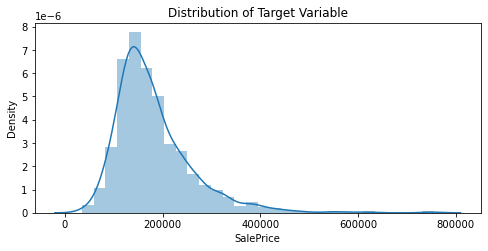

In [4]:
plt.figure(figsize=(8,3.5));
sns.distplot(df['SalePrice'],bins=30);
plt.title('Distribution of Target Variable');

### Check for Columns where more than 10% of the data is missing

In [4]:
missing = pd.DataFrame(df.isnull().sum()/df.shape[0],columns=['Percentage_Missing'])
missing.loc[missing['Percentage_Missing'] > 0.1]

,Percentage_Missing
LotFrontage,0.177397
Alley,0.937671
FireplaceQu,0.472603
PoolQC,0.995205
Fence,0.807534
MiscFeature,0.963014


1stFlrSF        0.457181
LotArea         0.426095
GrLivArea       0.402797
TotalBsmtSF     0.392075
TotRmsAbvGrd    0.352096
SalePrice       0.351799
GarageArea      0.344997
GarageCars      0.285691
Fireplaces      0.266639
Name: LotFrontage, dtype: float64

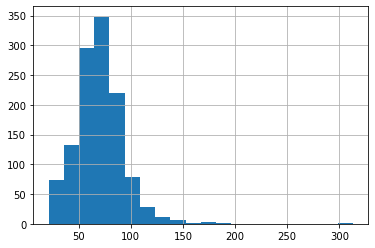

In [5]:
df['LotFrontage'].hist(bins=20);
df.corr()['LotFrontage'].sort_values(ascending=False)[1:10]

In [6]:
missing = pd.DataFrame(df.isnull().sum()/df.shape[0],columns=['Percentage_Missing'])
missing.loc[missing['Percentage_Missing'] > 0]

,Percentage_Missing
LotFrontage,0.177397
Alley,0.937671
MasVnrType,0.005479
MasVnrArea,0.005479
BsmtQual,0.025342
BsmtCond,0.025342
BsmtExposure,0.026027
BsmtFinType1,0.025342
BsmtFinType2,0.026027
Electrical,0.000685


In [7]:
impute_w_median = ['LotFrontage','MasVnrArea']
impute_w_noAccess = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']
impute_w_MostCommon = ['MasVnrType','Electrical']

In [8]:
fill_transformer = make_column_transformer(
    (SimpleImputer(strategy='median'), impute_w_median),
    (ImputerNoAccess(word_to_fill='No_Access'), impute_w_noAccess),
    (MostCommonImpute(),impute_w_MostCommon)
    ,remainder='passthrough'
)

In [9]:
new_df = fill_transformer.fit_transform(df)

<ipython-input-1-11da05fea00c>:34: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  x = pd.Series([])


In [10]:
changed_columns = np.concatenate([impute_w_median,impute_w_noAccess,impute_w_MostCommon])
not_changed_columns = []
for each in df.columns:
    if each not in changed_columns:
        not_changed_columns.append(each)
        
new_df_columns = np.concatenate([changed_columns, not_changed_columns])
new_df_up = pd.DataFrame(data=new_df, columns=new_df_columns)
new_df_up

,LotFrontage,MasVnrArea,Alley,FireplaceQu,PoolQC,Fence,MiscFeature,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,MasVnrType,Electrical,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice
0,65,196,No_Access,No_Access,No_Access,No_Access,No_Access,Gd,TA,No,GLQ,Unf,Attchd,2003,RFn,TA,TA,BrkFace,SBrkr,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2,548,Y,0,61,0,0,0,0,0,2,WD,Normal,208500
1,80,0,No_Access,TA,No_Access,No_Access,No_Access,Gd,TA,Gd,ALQ,Unf,Attchd,1976,RFn,TA,TA,None,SBrkr,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,2,460,Y,298,0,0,0,0,0,0,5,WD,Normal,181500
2,68,162,No_Access,TA,No_Access,No_Access,No_Access,Gd,TA,Mn,GLQ,Unf,Attchd,2001,RFn,TA,TA,BrkFace,SBrkr,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2,608,Y,0,42,0,0,0,0,0,9,WD,Normal,223500
3,60,0,No_Access,Gd,No_Access,No_Access,No_Access,TA,Gd,No,ALQ,Unf,Detchd,1998,Unf,TA,TA,None,SBrkr,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,3,642,Y,0,35,272,0,0,0,0,2,WD,Abnorml,140000
4,84,350,No_Access,TA,No_Access,No_Access,No_Access,Gd,TA,Av,GLQ,Unf,Attchd,2000,RFn,TA,TA,BrkFace,SBrkr,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,836,Y,192,84,0,0,0,0,0,12,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62,0,No_Access,TA,No_Access,No_Access,No_Access,Gd,TA,No,Unf,Unf,Attchd,1999,RFn,TA,TA,None,SBrkr,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,2,460,Y,0,40,0,0,0,0,0,8,WD,Normal,175000
1456,85,119,No_Access,TA,No_Access,MnPrv,No_Access,Gd,TA,No,ALQ,Rec,Attchd,1978,Unf,TA,TA,Stone,SBrkr,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,2,500,Y,349,0,0,0,0,0,0,2,WD,Normal,210000
1457,66,0,No_Access,Gd,No_Access,GdPrv,Shed,TA,Gd,No,GLQ,Unf,Attchd,1941,RFn,TA,TA,None,SBrkr,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,1,252,Y,0,60,0,0,0,0,2500,5,WD,Normal,266500
1458,68,0,No_Access,No_Access,No_Access,No_Access,No_Access,TA,TA,Mn,GLQ,Rec,Attchd,1950,Unf,TA,TA,None,FuseA,20,RL,9717,Pave,Reg,Lvl,AllPu

In [16]:
numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns
numerical_ix = numerical_ix.drop(labels=['SalePrice'])
categorical_ix = df.select_dtypes(include=['object']).columns
categorical_onehot = categorical_ix.drop(labels=['LotShape','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC'])
categorical_onehot = np.concatenate([categorical_onehot,['MSSubClass','LotShape']])
categorical_ordinal = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']
df[categorical_onehot] = df[categorical_onehot].astype('str')
ordinal_1 = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','PoolQC','GarageQual','GarageCond']
ordinal_2 = ['BsmtFinType1','BsmtFinType2']


In [17]:
full_transfortmer_ordinal = ColumnTransformer([
    ('std_scaller',StandardScaler(),numerical_ix),
    ('one_hot_dropfirst', OneHotEncoder(drop='first'), categorical_onehot),
    ('ordinal_1', Ordinal_Map(fill_dict=CAT_1),ordinal_1),
    ('ordinal_2', Ordinal_Map(fill_dict=CAT_2),ordinal_2)
], remainder='passthrough'
)

data_ordinal = full_transfortmer_ordinal.fit_transform(new_df_up)
column_names_ordinal = np.concatenate([numerical_ix,full_transfortmer_ordinal.transformers_[1][1].get_feature_names(),ordinal_1,ordinal_2,['SalePrice']])
final_df_ordinal = pd.DataFrame(data=data_ordinal, columns=column_names_ordinal)


In [18]:
full_transfortmer_drop = ColumnTransformer([
    ('std_scaller',StandardScaler(),numerical_ix),
    ('one_hot_dropfirst', OneHotEncoder(drop='first',sparse=False), np.concatenate([categorical_onehot,ordinal_1,ordinal_2]))]
, remainder='passthrough'
)

data_drop = full_transfortmer_drop.fit_transform(new_df_up)
column_names_drop = np.concatenate([numerical_ix,full_transfortmer_drop.transformers_[1][1].get_feature_names(),['SalePrice']])
final_df_drop = pd.DataFrame(data=data_drop, columns=column_names_drop)

In [19]:
full_transfortmer_full = ColumnTransformer([
    ('std_scaller',StandardScaler(),numerical_ix),
    ('one_hot_dropfirst', OneHotEncoder(sparse=False), np.concatenate([categorical_onehot,ordinal_1,ordinal_2]))]
, remainder='passthrough'
)

data_full = full_transfortmer_full.fit_transform(new_df_up)
column_names_full = np.concatenate([numerical_ix,full_transfortmer_full.transformers_[1][1].get_feature_names(),['SalePrice']])
final_df_full = pd.DataFrame(data=data_full, columns=column_names_full)

In [20]:
#arr_test = []
#for each in new_df_up.columns:
#    if each not in np.concatenate([numerical_ix,categorical_onehot,ordinal_1,ordinal_2]):
#        arr_test.append(each)

In [21]:
final_df_ordinal.to_csv('ordinal.csv',index=False)
final_df_drop.to_csv('drop.csv',index=False)
final_df_full.to_csv('full.csv',index=False)